#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Integration

Here, we consider the problem of numerically evaluating definite integrals
$$\int_a^b f(x) dx $$
and will mostly consider finite domains $-\infty < a < b < \infty$.
As with interpolation, we will be able to create very accurate and efficient methods for certain classes of functions while other functions will be more challenging.
For each integration technique we try, we're going to need to test its accuracy.
Let's create some test functions and their derivatives.

<IPython.core.display.Javascript object>


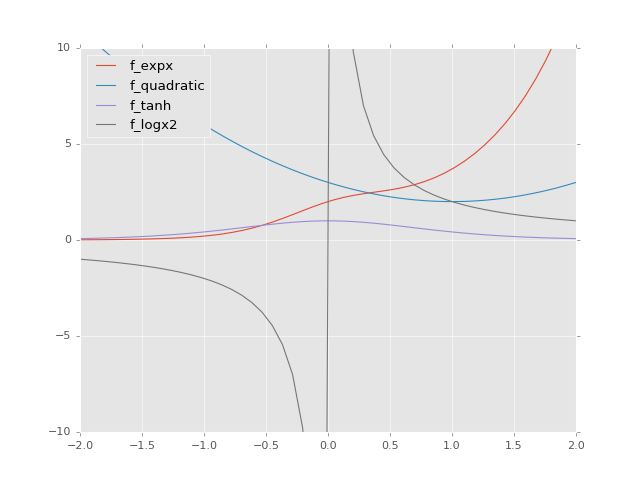

In [52]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

tests = []

@tests.append
class f_expx:
    def F(x):
        return numpy.exp(2*x)/(1+x**2)
    def f(x):
        return 2*numpy.exp(2*x)/(1+x**2) - numpy.exp(2*x)/(1+x**2)**2 * 2*x

@tests.append
class f_quadratic:
    def F(x):
        return x**3/3 - x**2 + 3*x - 1
    def f(x):
        return x**2 - 2*x + 3
    
@tests.append
class f_tanh:
    def F(x):
        return numpy.tanh(x)
    def f(x):
        return numpy.cosh(x)**(-2)
    
@tests.append
class f_logx2:
    def F(x):
        return numpy.log(x**2)
    def f(x):
        return 1/x**2 * 2*x

pyplot.style.use('ggplot')
pyplot.rcParams['figure.max_open_warning'] = False
pyplot.figure()
x = numpy.linspace(-2,2)
for t in tests:
    pyplot.plot(x, t.f(x), label=t.__name__)
pyplot.ylim(-10,10)
pyplot.legend(loc='upper left')

## Fundamental Theorem of Calculus

Let $f(x)$ be a continuous function and define $F(x)$ by
$$ F(x) = \int_a^x f(s) ds . $$
Then $F(x)$ is uniformly continuous, differentiable, and
$$ F'(x) = f(x) . $$
We say that $F$ is an antiderivative of $f$.
This implies that
$$ \int_a^b f(x) dx = F(b) - F(a) . $$
We will test the accuracy of our integration schemes using an antiderivative provided in our tests.

### Method of Manufactured Solutions

Analytically integrating an arbitrary function is hard, tends to require trickery, and is not always possible to express in closed form (e.g., [elliptic integrals](https://en.wikipedia.org/wiki/Elliptic_integral)).  In contrast, analytic differentiation involves straightforward application of the product rule and chain rule.  So if we just choose an arbitrary function $F$ (the antiderivative), we can compute $f = F'$, then numerically integrate $\int_a^b f$ and compare to $F(b) - F(a)$.  We have used this technique to produce the `tests` array above.

## Newton-Cotes methods

Newton-Cotes methods approximate $f(x)$ using piecewise polynomial functions.  Polynomials are easy to integrate analytically so we need only sum up the integrals over each piecewise interval.

### Midpoint rule

The midpoint method uses piecewise constant functions over some number $n$ of intervals.

In [56]:
def fint_midpoint(f, a, b, n=20):
    dx = (b - a)/n     # Width of each interval
    x = numpy.linspace(a+dx/2, b-dx/2, n)
    return numpy.sum(f(x))*dx

for t in tests:
    a, b = -2, 2.01
    I = fint_midpoint(t.f, a, b, 51)
    print('{:12s}: I={: 10e} error={: 10e}'.
          format(t.__name__, I, I - (t.F(b) - t.F(a))))

f_expx      : I= 1.104314e+01 error=-4.787618e-03
f_quadratic : I= 1.736137e+01 error=-2.065911e-03
f_tanh      : I= 1.928824e+00 error= 6.949352e-05
f_logx2     : I= 3.104142e+01 error= 3.103145e+01


<IPython.core.display.Javascript object>


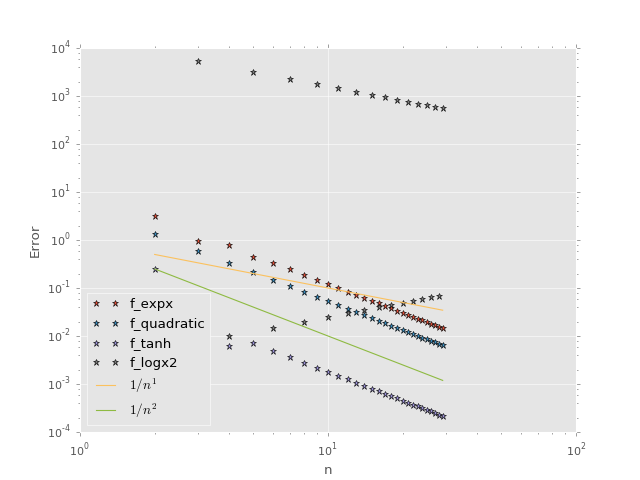

In [98]:
# How fast does this method converge?

def plot_accuracy(fint, tests, ns, ref=[1,2]):
    a, b = -2, 2.001
    ns = numpy.array(ns)
    pyplot.figure()
    for t in tests:
        Is = numpy.array([fint(t.f, a, b, n) for n in ns])
        Errors = numpy.abs(Is - (t.F(b) - t.F(a)))
        pyplot.loglog(ns, Errors, '*', label=t.__name__)
    for k in ref:
        pyplot.loglog(ns, 1/ns**k, label='$1/n^{:d}$'.format(k))
    pyplot.ylabel('Error')
    pyplot.xlabel('n')
    pyplot.legend(loc='lower left')
    
plot_accuracy(fint_midpoint, tests, range(2,30))

### Measuring cost

A common situation with numerical integration is that the function $f(x)$ has a significant cost relative to the additions and multiplications needed to scale and sum the values.  The cost per integration point is constant for most methods that we will consider, therefore the number of function evaluations $n$ is a good measure of the cost.  Some algorithms may have higher cost per quadrature point in which case we will need to trade off the superlinear cost of quadrature with the linear cost of evaluating the function.

### Trapezoid Rule

The trapezoid rule uses piecewise linear functions on each interval.

$$\begin{split} \int_a^b f(a) + \frac{f(b) - f(a)}{b - a} (x - a) &= f(a) (x-a) + \frac{f(b) - f(a)}{2(b - a)} (x - a)^2 \Big|_{x=a}^b \\
&= f(a) (b-a) + \frac{f(b) - f(a)}{2(b - a)} (b-a)^2 \\
&= \frac{b-a}{2} \big( f(a) + f(b) \big) .
\end{split} $$

* Can you get to the same result using a geometric argument?
* What happens when we sum over a bunch of adjacent intervals?

In [63]:
x = numpy.linspace(-1,2,4)
print(x[0:2])
ix = [0,2]
print(x[ix])
print(x[[0,-1]])

[-1.  0.]
[-1.  1.]
[-1.  2.]


<IPython.core.display.Javascript object>


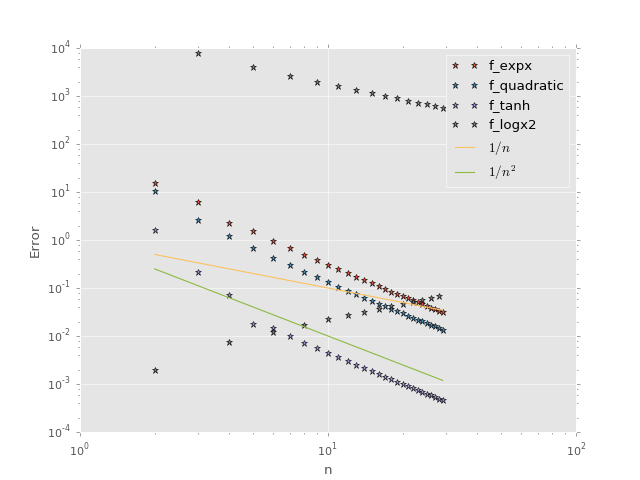

In [64]:
def fint_trapezoid(f, a, b, n=20):
    dx = (b - a) / (n - 1)     # We evaluate endpoints of n-1 intervals
    x = numpy.linspace(a, b, n)
    fx = f(x)
    fx[[0,-1]] *= .5
    # fx[0] *= .5; fx[-1] *= .5
    return numpy.sum(fx)*dx

plot_accuracy(fint_trapezoid, tests, range(2,30))

In [80]:
for t in tests:
    a, b = -2, 2
    npoints = 10*2**numpy.arange(5)
    for n in npoints:
        I = fint_trapezoid(t.f, a, b, n)
        print('{:12s}: n={: 4d} I={: 10f} error={: 10f}'.
              format(t.__name__, n, I, I - (t.F(b) - t.F(a))))

f_expx      : n=  10 I= 11.215143 error=  0.299176
f_expx      : n=  20 I= 10.983499 error=  0.067532
f_expx      : n=  40 I= 10.932016 error=  0.016049
f_expx      : n=  80 I= 10.919879 error=  0.003913
f_expx      : n= 160 I= 10.916933 error=  0.000966
f_quadratic : n=  10 I= 17.465021 error=  0.131687
f_quadratic : n=  20 I= 17.362881 error=  0.029548
f_quadratic : n=  40 I= 17.340346 error=  0.007013
f_quadratic : n=  80 I= 17.335042 error=  0.001709
f_quadratic : n= 160 I= 17.333755 error=  0.000422
f_tanh      : n=  10 I=  1.923617 error= -0.004438
f_tanh      : n=  20 I=  1.927051 error= -0.001004
f_tanh      : n=  40 I=  1.927816 error= -0.000239
f_tanh      : n=  80 I=  1.927997 error= -0.000058
f_tanh      : n= 160 I=  1.928041 error= -0.000014
f_logx2     : n=  10 I=  0.000000 error=  0.000000
f_logx2     : n=  20 I=  0.000000 error=  0.000000
f_logx2     : n=  40 I=  0.000000 error=  0.000000
f_logx2     : n=  80 I=  0.000000 error=  0.000000
f_logx2     : n= 160 I= -0.0000

## Extrapolation

Looking above, we see that once we enter the asymptotic regime, errors are monotonic.  That is, the error is either all positive or all negative, and the magnitude is cut by a factor of 4 on each doubling of the number of points $n$.

<IPython.core.display.Javascript object>


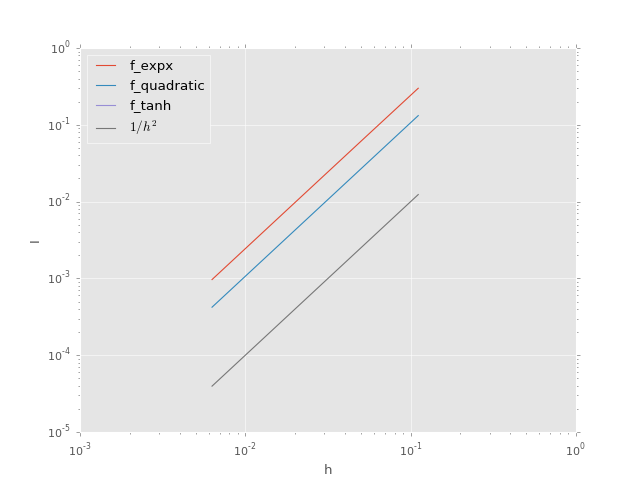

In [85]:
pyplot.figure()
for t in tests[:-1]:
    h = 1/(npoints - 1)
    pyplot.loglog(h, [fint_trapezoid(t.f, a, b, n) - (t.F(b) - t.F(a))
                        for n in npoints], label=t.__name__)
pyplot.loglog(h, h**2, label='$1/h^2$')
pyplot.xlabel('h')
pyplot.ylabel('I')
pyplot.legend(loc='upper left')

The trapezoid rule with $n$ points has an interval spacing of $h = 1/(n-1)$.  Let $I_h$ be the value of the integral approximated using an interval $h$.  We have numerical evidence that the leading error term is $O(h^2)$, i.e.,
$$ I_h - I_0 = c h^2 + O(h^3) $$
for some as-yet unknown constant $c$ that will depend on the function being integrated and the domain of integration.
If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h=0$.
For sufficiently small $h$, we can neglect $O(h^3)$ and write
$$\begin{split} I_h - I_0 &= c h^2 \\
I_{2h} - I_0 &= c (2h)^2 .
\end{split}$$
Subtracting these two lines, we have
$$ I_{h} - I_{2h} = c (h^2 - 4 h^2) $$
which can be solved for $c$ as
$$ c = \frac{I_{h} - I_{2h}}{h^2 - 4 h^2} . $$
Substituting back into the first equation, we solve for $I_0$ as
$$ I_0 = I_h - c h^2 = I_h + \frac{I_{h} - I_{2h}}{4 - 1} .$$
This is called **Richardson extrapolation**.

In [89]:
for t in tests[:-1]:
    a, b = -2, 2
    for n in [10, 20, 40]:
        I_h = fint_trapezoid(t.f, a, b, n)
        I_2h = fint_trapezoid(t.f, a, b, n//2)
        I_extrap = I_h + (I_h - I_2h) / 3
        I_exact = t.F(b) - t.F(a)
        print('{:12s}: n={: 4d} error={: 10f} {: 10f} {: 10f}'.
              format(t.__name__, n, I_h-I_exact, I_2h-I_exact, I_extrap-I_exact))

f_expx      : n=  10 error=  0.299176   1.538470  -0.113922
f_expx      : n=  20 error=  0.067532   0.299176  -0.009682
f_expx      : n=  40 error=  0.016049   0.067532  -0.001112
f_quadratic : n=  10 error=  0.131687   0.666667  -0.046639
f_quadratic : n=  20 error=  0.029548   0.131687  -0.004499
f_quadratic : n=  40 error=  0.007013   0.029548  -0.000499
f_tanh      : n=  10 error= -0.004438  -0.017456  -0.000099
f_tanh      : n=  20 error= -0.001004  -0.004438   0.000141
f_tanh      : n=  40 error= -0.000239  -0.001004   0.000016


#### Observations
* Sometimes extrapolation gives more accuracy than doubling the number of points.
* The total number of function evaluations is $n + n/2$.
* Can we get away with fewer function evaluations?

<IPython.core.display.Javascript object>


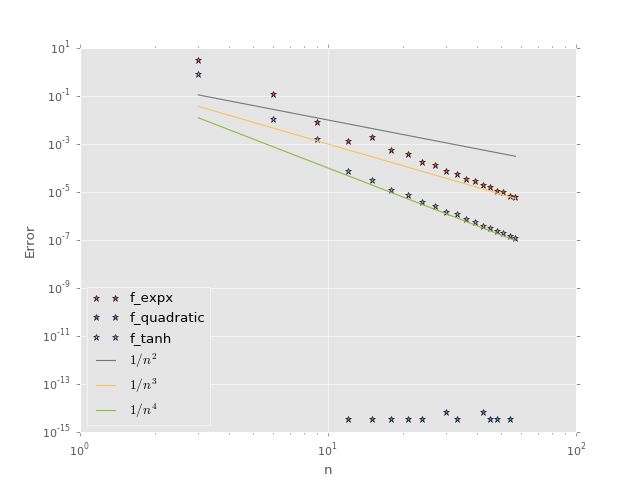

In [99]:
def fint_richardson(f, a, b, n):
    n = (n // 2) * 2 + 1
    dx = (b - a) / (n - 1)
    x = numpy.linspace(a, b, n)
    fx = f(x)
    fx[[0,-1]] *= .5
    I_h = numpy.sum(fx)*dx
    I_2h = numpy.sum(fx[::2])*2*dx
    return I_h + (I_h - I_2h) / 3

plot_accuracy(fint_richardson, tests[:-1], range(3,60,3), ref=[2,3,4])

Evidently we created a *fourth order* accurate method by extrapolating a second order accurate method.
This process can even be applied **recursively**!

## Gauss Quadrature

Recall the Legendre polynomials from the **Interpolation** unit.  These polynomials were orthogonal, so if we have a polynomial represented in the basis of Legendre polynomials, i.e.,
$$ p_n(x) = \sum_i c_i P_i(x) $$
where $P_i(x)$ is the $i$th Legendre polynomial, then
$$ \int_{-1}^1 p_n(x) = 2 c_0 . $$

* Given a set of points $\{x_i\}$, how can we determine $c_0$?

<IPython.core.display.Javascript object>


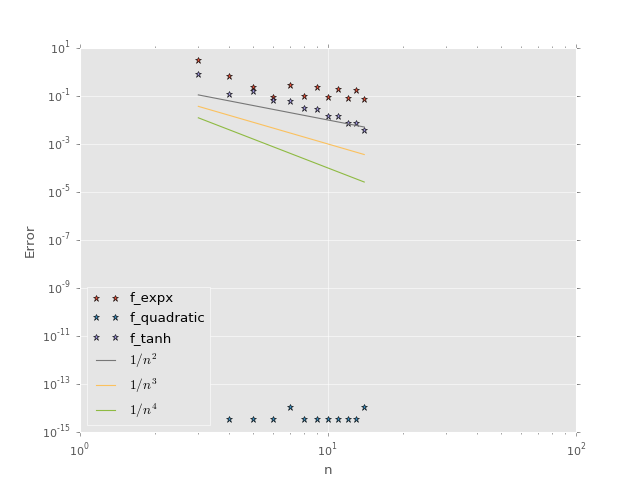

In [123]:
def vander_legendre(x, n=None):
    if n is None:
        n = len(x)
    P = numpy.ones((len(x), n))
    if n > 1:
        P[:,1] = x
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
    return P

def fint_legendre_lin(f, a, b, n):
    x = numpy.linspace(a, b, n)
    fx = f(x)
    P = vander_legendre(numpy.linspace(-1,1,n))
    c = numpy.linalg.solve(P, fx)
    return c[0] * (b-a)

plot_accuracy(fint_legendre_lin, tests[:-1], range(3,15), ref=[2,3,4])

#### Observations
* This is promising -- convergence is pretty fast.
* Convergence is erratic.  Why?

<IPython.core.display.Javascript object>


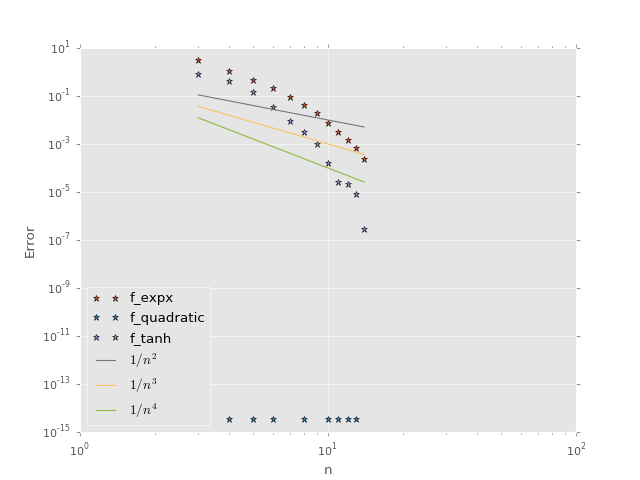

In [125]:
def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(0, numpy.pi, n)))

def fint_legendre_cos(f, a, b, n):
    x = cosspace(a, b, n)
    fx = f(x)
    P = vander_legendre(cosspace(-1,1,n))
    c = numpy.linalg.solve(P, fx)
    return c[0] * (b-a)

fint_legendre_cos(tests[0].f, -2, 2, 10), tests[0].F(2) - tests[0].F(-2)

plot_accuracy(fint_legendre_cos, tests[:-1], range(3,15), ref=[2,3,4])